<a href="https://colab.research.google.com/github/RainiBenaiah/Sentiment-Analysis-Group_10/blob/main/sentiment_analysis_traditional_modelGP10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install or upgrade datasets and fsspec
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/amazon_polarity")

In [ ]:
# IMPORTS(NECESSARY LIBRARIES)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Exploratory Data Analysis

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})


In [ ]:
print(ds['train'][0])  # Look at a sample

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [ ]:
print(f"Train size: {len(ds['train'])}")

Train size: 3600000


In [ ]:
print(f"Test size: {len(ds['test'])}")

Test size: 400000


In [ ]:
# Check class distribution
import pandas as pd
train_data = pd.DataFrame(ds['train'])
print("\nClass distribution in training set:")
print(train_data['label'].value_counts())


Class distribution in training set:
label
1    1800000
0    1800000
Name: count, dtype: int64


In [ ]:
# Basic structure of the two sets

train_data = ds['train'].to_pandas()
test_data = ds['test'].to_pandas()

print('Train data')
train_data.info()
train_data.head()

print('Test data')
test_data.info()
test_data.head()

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   label    int64 
 1   title    object
 2   content  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
Test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    400000 non-null  int64 
 1   title    400000 non-null  object
 2   content  400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


,label,title,content
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [ ]:
# Sampling function to handle large dataset
def get_balanced_sample(dataset, sample_size=10000, random_state=42):
    """Get a balanced sample from the dataset"""
    df = dataset.to_pandas()
    df_0 = df[df['label'] == 0]
    df_1 = df[df['label'] == 1]

    sample_per_class = sample_size // 2
    sample_0 = resample(df_0, n_samples=sample_per_class, random_state=random_state)
    sample_1 = resample(df_1, n_samples=sample_per_class, random_state=random_state)

    return pd.concat([sample_0, sample_1]).sample(frac=1, random_state=random_state)


In [ ]:
# Load and sample data
train_sample = get_balanced_sample(ds['train'], sample_size=20000)
test_sample = get_balanced_sample(ds['test'], sample_size=5000)

In [ ]:
# Recompute content lengths on samples
train_sample['content_length'] = train_sample['content'].str.split().str.len()
test_sample['content_length'] = test_sample['content'].str.split().str.len()


In [ ]:
# Statistical Analysis and Visualizations


# Style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("=== DATASET OVERVIEW ===")
print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")



# Llabel distribution analysis
print("\n=== LABEL DISTRIBUTION ANALYSIS ===")
print("\nTrain Label Distribution:")
print(train_data['label'].value_counts(normalize=True))

print("\nTest Label Distribution:")
print(test_data['label'].value_counts(normalize=True))

=== DATASET OVERVIEW ===
Train shape: (3600000, 3)
Test shape: (400000, 3)

=== LABEL DISTRIBUTION ANALYSIS ===

Train Label Distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test Label Distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
print(" DATASET OVERVIEW")
print(f"Train Sample shape: {train_sample.shape}")
print(f"Test Sample shape: {test_sample.shape}")

 DATASET OVERVIEW
Train Sample shape: (20000, 4)
Test Sample shape: (5000, 4)


In [ ]:
# Label distribution
print(" LABEL DISTRIBUTION (for Sampled data)")
print(train_sample['label'].value_counts(normalize=True))
print(test_sample['label'].value_counts(normalize=True))

 LABEL DISTRIBUTION (for Sampled data)
label
1    0.5
0    0.5
Name: proportion, dtype: float64
label
0    0.5
1    0.5
Name: proportion, dtype: float64


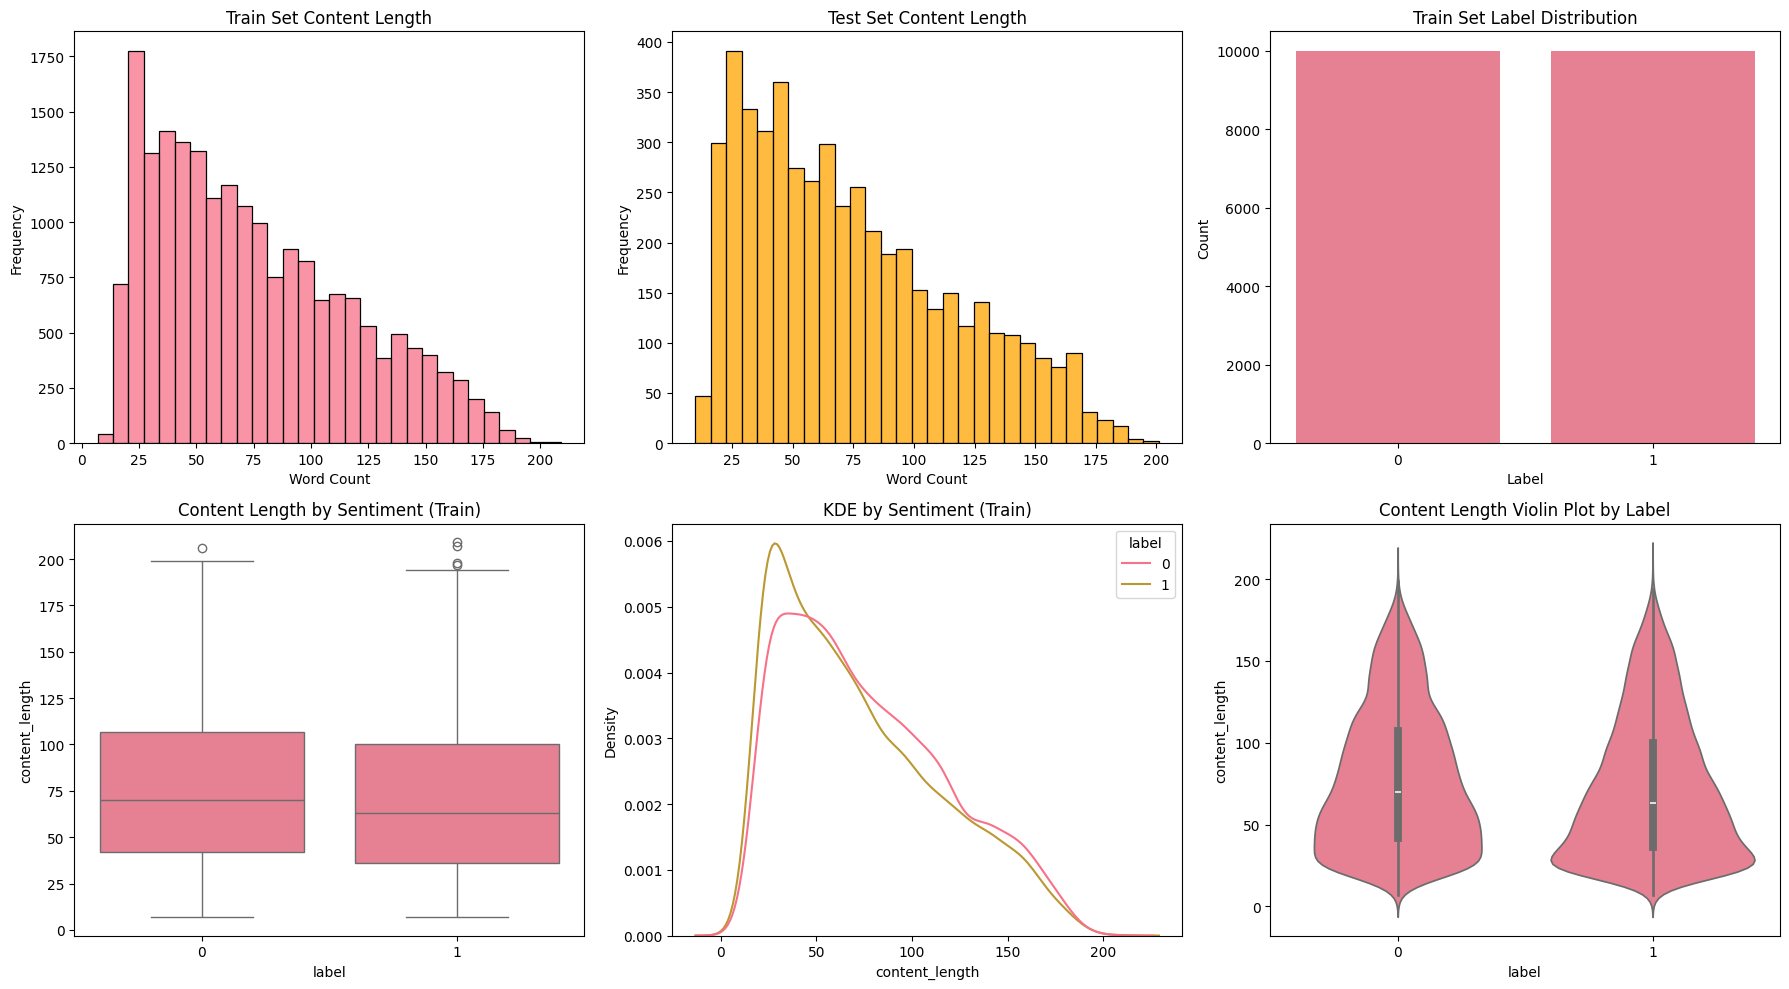

In [ ]:


# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Content length distribution
sns.histplot(train_sample['content_length'], bins=30, ax=axes[0, 0], kde=False)
axes[0, 0].set_title('Train Set Content Length')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(test_sample['content_length'], bins=30, ax=axes[0, 1], color='orange', kde=False)
axes[0, 1].set_title('Test Set Content Length')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Label distribution
sns.countplot(x='label', data=train_sample, ax=axes[0, 2])
axes[0, 2].set_title('Train Set Label Distribution')
axes[0, 2].set_xlabel('Label')
axes[0, 2].set_ylabel('Count')

# Content length vs label
sns.boxplot(x='label', y='content_length', data=train_sample, ax=axes[1, 0])
axes[1, 0].set_title('Content Length by Sentiment (Train)')

# Density plot (Kernel Density Estimation)
sns.kdeplot(data=train_sample, x='content_length', hue='label', ax=axes[1, 1])
axes[1, 1].set_title('KDE by Sentiment (Train)')

# Word count distribution by sentiment (violin plot)
sns.violinplot(x='label', y='content_length', data=train_sample, ax=axes[1, 2])
axes[1, 2].set_title('Content Length Violin Plot by Label')

plt.tight_layout()
plt.show()

# Preprocess Text

In [ ]:
def preprocess_text(text):
    """Comprehensive text preprocessing function"""

    # Handle potential non-string inputs gracefully
    if not isinstance(text, str):
        return "" # Or handle as appropriate, returning an empty string for now

    # 1. Remove HTML tags (though this Amazon reviews(this dataset) may not have much HTML)
    text = re.sub(r'<[^>]+>', '', text)

    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Remove non-alphabetic characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Convert to lowercase
    text = text.lower()

    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenization
    tokens = word_tokenize(text)

    # 7. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 8. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to string
    return ' '.join(tokens)

In [ ]:
# Apply your preprocessing to the samples
train_sample['processed_content'] = train_sample['content'].apply(preprocess_text)
test_sample['processed_content'] = test_sample['content'].apply(preprocess_text)



## Verification

In [ ]:
print("\nClass distribution in train sample:")
print(train_sample['label'].value_counts())
print("\nClass distribution in test sample:")
print(test_sample['label'].value_counts())


Class distribution in train sample:
label
1    10000
0    10000
Name: count, dtype: int64

Class distribution in test sample:
label
0    2500
1    2500
Name: count, dtype: int64


# Let Verify the outputs that show side-by-side comparisons of original vs. processed text, and quality checks after sampling


In [ ]:
# --- VERIFICATION OUTPUTS ---
print("\n" + "="*50)
print("PREPROCESSING VERIFICATION")
print("="*50 + "\n")

# 1. Show random original vs processed pairs
print("1. SIDE-BY-SIDE TEXT COMPARISON:")
for _ in range(3):  # Show 3 random examples
    idx = train_sample.sample(1).index[0]
    original = train_sample.loc[idx, 'content']
    processed = train_sample.loc[idx, 'processed_content']

    print(f"\nLABEL: {'POSITIVE' if train_sample.loc[idx, 'label'] else 'NEGATIVE'}")
    print(f"\nORIGINAL:\n{original[:500]}...")  # First 500 chars
    print(f"\nPROCESSED:\n{processed}")
    print("-"*80)

# 2. Empty text check
empty_count = train_sample['processed_content'].str.strip().eq('').sum()
print(f"\n2. EMPTY TEXT CHECK: {empty_count}/{len(train_sample)} texts became empty after preprocessing")

# 3. Length distribution comparison
train_sample['original_length'] = train_sample['content'].str.split().str.len()
train_sample['processed_length'] = train_sample['processed_content'].str.split().str.len()

print("\n3. LENGTH DISTRIBUTION (words per review):")
print(train_sample[['original_length', 'processed_length']].describe())

# 4. Vocabulary size check
all_words = ' '.join(train_sample['processed_content']).split()
print(f"\n4. VOCABULARY SIZE: {len(set(all_words))} unique words in processed sample")

# 5. Most common words check
from collections import Counter
top_words = Counter(all_words).most_common(10)
print("\n5. TOP 10 WORDS IN PROCESSED DATA:")
for word, count in top_words:
    print(f"{word}: {count}")


PREPROCESSING VERIFICATION

1. SIDE-BY-SIDE TEXT COMPARISON:

LABEL: POSITIVE

ORIGINAL:
Very nice set, way too many for my needs but they are well made and do what they are intended to do. Well worth the cost....

PROCESSED:
nice set way many need well made intended well worth cost
--------------------------------------------------------------------------------

LABEL: NEGATIVE

ORIGINAL:
These candies were just mediocre in flavor. When you first put them in your mouth, they taste bitter and powdery but as you chew, the flavor does improve a bit. I don't really recommend them....

PROCESSED:
candy mediocre flavor first put mouth taste bitter powdery chew flavor improve bit dont really recommend
--------------------------------------------------------------------------------

LABEL: NEGATIVE

ORIGINAL:
Sean cranks out more double-speak and spin than Ann Coulter in a hot tub with Rush Limbaugh and Michael Savage.More overly simplified 'shouting points' from the Bully King of Fox News C

In [ ]:

# FEATURE EXTRACTION (TF-IDF)


tfidf = TfidfVectorizer(
    max_features=15_000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True,
    use_idf=True
)

X_train = tfidf.fit_transform(train_sample['processed_content'])
X_test = tfidf.transform(test_sample['processed_content'])
y_train = train_sample['label']
y_test = test_sample['label']

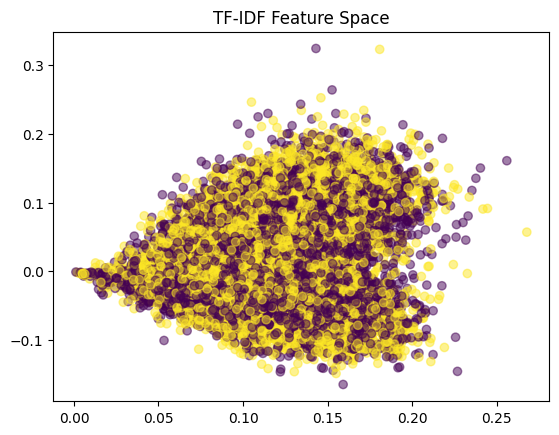

In [ ]:
# Vsualization

# Reduce to 2D for visualization
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_train)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, alpha=0.5)
plt.title("TF-IDF Feature Space")
plt.show()

In [ ]:
# Analyze the extracted features
feature_names = tfidf.get_feature_names_out()
print(f"Total vocabulary size: {len(feature_names)}")

# Check n-gram distribution
bigrams = [f for f in feature_names if ' ' in f]
print(f"\nSample bigrams: {bigrams[:10]}")
print(f"Bigrams ratio: {len(bigrams)/len(feature_names):.1%}")

# Document frequency stats
print("\nTerm frequency distribution:")
print(pd.Series(tfidf.idf_).describe())

Total vocabulary size: 15000

Sample bigrams: ['aa battery', 'able find', 'able finish', 'able get', 'able play', 'able put', 'able read', 'able see', 'able take', 'able use']
Bigrams ratio: 45.0%

Term frequency distribution:
count    15000.000000
mean         7.938499
std          0.992007
min          2.285052
25%          7.536242
50%          8.264480
75%          8.600952
max          9.111778
dtype: float64


In [ ]:

# MODEL TRAINING

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=42
)
logreg.fit(X_train, y_train)

# Evaluation
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2500
           1       0.84      0.85      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [ ]:

# HYPERPARAMETER TUNING
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Add this AFTER your initial evaluation
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

params = {
    'tfidf__max_features': [10_000, 20_000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(pipeline, params, cv=3, n_jobs=-1)
grid.fit(train_sample['processed_content'], y_train)

print("Best params:", grid.best_params_)

Best params: {'clf__C': 1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [ ]:
# Get most influential words for each class
feature_names = tfidf.get_feature_names_out()
coefs = logreg.coef_[0]

# Top 10 positive/negative words
top_positive = sorted(zip(coefs, feature_names), reverse=True)[:10]
top_negative = sorted(zip(coefs, feature_names))[:10]

print("\nTop POSITIVE words (predicting class 1):")
for coef, word in top_positive:
    print(f"{word}: {coef:.3f}")

print("\nTop NEGATIVE words (predicting class 0):")
for coef, word in top_negative:
    print(f"{word}: {coef:.3f}")


Top POSITIVE words (predicting class 1):
great: 8.554
love: 6.741
best: 5.175
easy: 4.954
excellent: 4.854
perfect: 4.692
favorite: 4.429
enjoyed: 3.717
wonderful: 3.593
life: 3.362

Top NEGATIVE words (predicting class 0):
boring: -6.423
disappointed: -5.631
worst: -5.572
waste: -5.133
poor: -4.795
money: -4.657
horrible: -4.199
nothing: -4.133
bad: -4.065
return: -3.945


In [ ]:
def predict_sentiment(model, tfidf, new_reviews):
    """
    Predict sentiment for raw new reviews
    Args:
        model: Your trained LogisticRegression
        tfidf: Your fitted TfidfVectorizer
        new_reviews: List of raw review strings
    Returns:
        List of predictions (0=negative, 1=positive)
    """
    # Preprocess (using your exact preprocessing function)
    processed = [preprocess_text(review) for review in new_reviews]

    # Transform using existing TF-IDF
    X_new = tfidf.transform(processed)

    # Predict
    return model.predict(X_new)

# Sample new reviews (examples)
new_reviews = [
    "This product is amazing! Worth every penny.",
    "Terrible quality, broke after 2 days.",
    "It's okay but not what I expected."
]
# Make predictions
predictions = predict_sentiment(logreg, tfidf, new_reviews)


In [ ]:
print(predictions)

[1 0 0]


In [ ]:
def predict_with_confidence(model, tfidf, new_reviews):
    """Add probability scores to predictions"""
    processed = [preprocess_text(review) for review in new_reviews]
    X_new = tfidf.transform(processed)

    probs = model.predict_proba(X_new)
    return [
        {
            "review": review,
            "prediction": "POSITIVE" if pred == 1 else "NEGATIVE",
            "confidence": max(prob),
            "prob_negative": prob[0],
            "prob_positive": prob[1]
        }
        for review, pred, prob in zip(new_reviews, model.predict(X_new), probs)
    ]

# Get detailed predictions
prediction_results = predict_with_confidence(logreg, tfidf, new_reviews)

# Pretty print
import pandas as pd
print(pd.DataFrame(prediction_results))

                                        review prediction  confidence  \
0  This product is amazing! Worth every penny.   POSITIVE    0.934798   
1        Terrible quality, broke after 2 days.   NEGATIVE    0.971539   
2           It's okay but not what I expected.   NEGATIVE    0.825418   

   prob_negative  prob_positive  
0       0.065202       0.934798  
1       0.971539       0.028461  
2       0.825418       0.174582  


In [ ]:
# Test controversial cases
controversial = [
    "Not bad for the price",
    "I don't hate it but would never recommend",
    "Meh, it's fine"
]
print(pd.DataFrame(predict_with_confidence(logreg, tfidf, controversial)))

                                      review prediction  confidence  \
0                      Not bad for the price   NEGATIVE    0.725512   
1  I don't hate it but would never recommend   NEGATIVE    0.858578   
2                             Meh, it's fine   POSITIVE    0.618460   

   prob_negative  prob_positive  
0       0.725512       0.274488  
1       0.858578       0.141422  
2       0.381540       0.618460  
